In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


--2025-03-09 02:26:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-03-09 02:26:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-03-09 02:26:44--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [2]:
!pip install tensorflow

In [12]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Lambda, Bidirectional, Reshape
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [14]:
## Step 1: Load Datasets

def load_dataset(path):
    df = pd.read_csv(path)
    sentences = df['text'].astype(str).tolist() # Explicitly cast to string
    labels = df['label'].tolist()

    return sentences, labels

train_sentences, train_labels = load_dataset('Train.csv')
test_sentences, test_labels = load_dataset('Test.csv')
valid_sentences, valid_labels = load_dataset('Valid.csv')

# Combine all sentences for tokenizer fitting
all_sentences = train_sentences + test_sentences + valid_sentences

print(len(all_sentences))


def preprocess_text(text):
    return word_tokenize(text.lower())




50000


In [15]:
## Step 2: Create Word-to-Index Mapping using Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<UNK>")  # Limit vocabulary size to top 10,000 words + OOV token
tokenizer.fit_on_texts(all_sentences)

word_to_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
index_to_word = {index: word for word, index in word_to_index.items()}

# Add padding token (it might already be present, but let's ensure it)
if "<PAD>" not in word_to_index:
    word_to_index['<PAD>'] = 0
    index_to_word[0] = '<PAD>'


In [16]:
## Step 3: Convert Sentences to Sequences and Pad Them

def convert_and_pad(sentences, tokenizer, max_length):
    sequences = tokenizer.texts_to_sequences(sentences)  # Use tokenizer to convert to sequences
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post', value=word_to_index['<PAD>']) # Pad sequences
    return padded_sequences

max_length = 200  # Set a maximum sequence length
X_train = convert_and_pad(train_sentences, tokenizer, max_length)
X_test = convert_and_pad(test_sentences, tokenizer, max_length)
X_val = convert_and_pad(valid_sentences, tokenizer, max_length)

y_train = np.array(train_labels)
y_test = np.array(test_labels)
y_val = np.array(valid_labels)

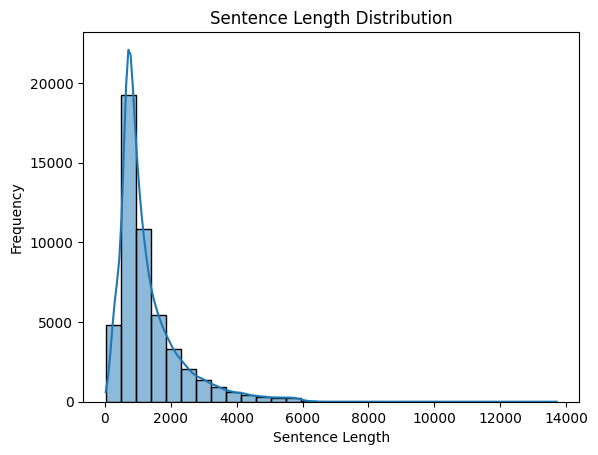

In [17]:
# Plot sentence length distribution
dataset_tuples = list(zip(train_sentences, train_labels)) + list(zip(test_sentences, test_labels)) + list(zip(valid_sentences, valid_labels))
sentence_lengths = [len(text) for text, _ in dataset_tuples]
sns.histplot(sentence_lengths, bins=30, kde=True)
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Sentence Length Distribution')
plt.show()

In [18]:
# Load pre-trained GloVe embeddings
def load_glove_embeddings(file_path, embedding_dim):
    """Loads GloVe embeddings from file and creates embedding matrix."""

    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_to_index.items():
        vector = embeddings_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector
    return embedding_matrix

In [19]:
glove_embedding_matrix = load_glove_embeddings("/content/glove.6B.100d.txt", 100)

In [20]:
# Define LSTM model with GloVe
def build_lstm_model(embedding_matrix):
    """Builds an LSTM model using pre-trained GloVe embeddings."""
    model = Sequential([
        Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False),
        Bidirectional(LSTM(64, return_sequences=True)),
        LSTM(32),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

glove_model = build_lstm_model(glove_embedding_matrix)
glove_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 355s 280ms/step - accuracy: 0.5432 - loss: 0.6843 - val_accuracy: 0.6038 - val_loss: 0.6658
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 381s 279ms/step - accuracy: 0.6617 - loss: 0.6169 - val_accuracy: 0.8102 - val_loss: 0.4080
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 379s 277ms/step - accuracy: 0.8212 - loss: 0.3969 - val_accuracy: 0.8466 - val_loss: 0.3469
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 385s 279ms/step - accuracy: 0.8519 - loss: 0.3384 - val_accuracy: 0.8602 - val_loss: 0.3218
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 381s 278ms/step - accuracy: 0.8690 - loss: 0.3076 - val_accuracy: 0.8730 - val_loss: 0.2997


In [21]:
# Load ELMo model from TensorFlow Hub
elmo = hub.load("https://tfhub.dev/google/elmo/3")

# Function to generate ELMo embeddings
def elmo_vectors(text_list):
    embeddings = elmo.signatures["default"](tf.constant(text_list))["elmo"]
    return embeddings.numpy()

In [22]:
def generate_elmo_embeddings(vocab, tokenizer):
    emb_matrix = np.zeros((vocab_size, 1024))  # ELMo embeddings are 1024-dim
    batch_size = 1000

    for i in range(0, len(vocab), batch_size):
        batch_words = vocab[i : i + batch_size]
        embeddings = elmo_vectors(batch_words)
        for word, emb in zip(batch_words, embeddings):
            index = tokenizer.word_index.get(word, 0)
            if index < vocab_size:
                emb_matrix[index] = emb

    return emb_matrix

In [23]:
vocab = list(tokenizer.word_index.keys())
elmo_embedding_matrix = generate_elmo_embeddings(vocab, tokenizer)

In [24]:
def build_lstm_model(embedding_matrix):
    """Builds an LSTM model using pre-trained GloVe embeddings."""

    model = Sequential([
        Embedding(vocab_size, 1024, weights=[embedding_matrix], trainable=False),
        Bidirectional(LSTM(64, return_sequences=True)),
        LSTM(32),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

elmo_model = build_lstm_model(elmo_embedding_matrix)
elmo_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1005s 799ms/step - accuracy: 0.5724 - loss: 0.6361 - val_accuracy: 0.8576 - val_loss: 0.3317
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1038s 795ms/step - accuracy: 0.8575 - loss: 0.3312 - val_accuracy: 0.8660 - val_loss: 0.3097
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1010s 770ms/step - accuracy: 0.8747 - loss: 0.2966 - val_accuracy: 0.8698 - val_loss: 0.3090
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1015s 796ms/step - accuracy: 0.8892 - loss: 0.2683 - val_accuracy: 0.8632 - val_loss: 0.3196
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1035s 791ms/step - accuracy: 0.9009 - loss: 0.2453 - val_accuracy: 0.8684 - val_loss: 0.3056


Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)
<table>
  <tr>
    <th>sno</th>
    <th>Parameters</th>
    <th>Justification</th>
  </tr>
  <tr>
    <td>1</td>
    <td>vocab_size</td>
    <td>The size of the vocabulary (i.e., the number of unique words in the dataset).</td>
  </tr>
  <tr>
    <td>2</td>
    <td>100</td>
    <td>The output dimension of the embedding layer </td>
  </tr>
  <tr>
    <td>3</td>
    <td>weights=[embedding_matrix]</td>
    <td> Pre-trained word embeddings </td>
  </tr>
  <tr>
    <td>4</td>
    <td>trainable=False</td>
    <td>embedding weights are frozen</td>
  </tr>
  <tr>
    <td>5</td>
    <td>Bidirectional(LSTM(64, return_sequences=True))</td>
    <td>A Long Short-Term Memory (LSTM) layer with 64 units utputs a sequence instead of a single value, allowing it to be passed to the next LSTM layer Wraps the LSTM layer so that it processes the input from both forward and backward directions. </td>
  </tr>
  <tr>
    <td>6</td>
    <td>LSTM(32)</td>
    <td> This LSTM layer has 32 memory cells. It receives the output from the previous Bidirectional LSTM layer </td>
  </tr>
  <tr>
    <td>7</td>
    <td>Dense(1, activation='sigmoid')</td>
    <td> This is a binary classification task It receives  a range between 0 and 1, which is ideal for binary classification. </td>
  </tr>
</table>

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<table>
  <tr>
    <th>sno</th>
    <th>Parameters</th>
    <th>Justification</th>
  </tr>
  <tr>
    <td>1</td>
    <td>loss='binary_crossentropy'</td>
    <td>Binary cross-entropy loss is used because the model is performing binary classification.</td>
  </tr>
  <tr>
    <td>2</td>
    <td>optimizer='adam'</td>
    <td>Adam (Adaptive Moment Estimation) is chosen for optimization as it efficiently adjusts learning rates and works well for most deep learning tasks. </td>
  </tr>
  <tr>
    <td>3</td>
    <td>metrics=['accuracy']</td>
    <td> Accuracy is used as the evaluation metric to measure model performance. </td>
  </tr>
  </table>


In [25]:
glove_loss, glove_acc = glove_model.evaluate(X_test, y_test)
elmo_loss, elmo_acc = elmo_model.evaluate(X_test, y_test)

print(f'GloVe Model Accuracy: {glove_acc * 100:.2f}%')
print(f'ELMo Model Accuracy: {elmo_acc * 100:.2f}%')

157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - accuracy: 0.8604 - loss: 0.3179
157/157 ━━━━━━━━━━━━━━━━━━━━ 46s 291ms/step - accuracy: 0.8618 - loss: 0.3267
GloVe Model Accuracy: 86.98%
ELMo Model Accuracy: 86.24%


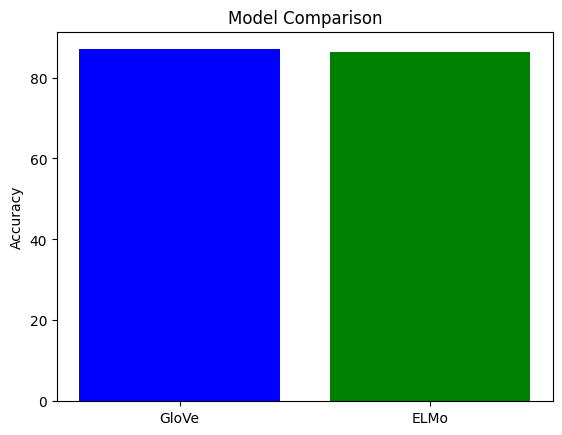

In [26]:
metrics = ['GloVe', 'ELMo']
accuracies = [glove_acc * 100, elmo_acc * 100]
plt.bar(metrics, accuracies, color=['blue', 'green'])
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()

<table border="1">
    <tr>
        <th>Feature</th>
        <th>ELMo</th>
        <th>GloVe</th>
    </tr>
    <tr>
        <td>Model Type</td>
        <td>Contextual Word Embeddings</td>
        <td>Static Word Embeddings</td>
    </tr>
    <tr>
        <td>Training Approach</td>
        <td>Trained using deep bidirectional LSTMs (language model-based)</td>
        <td>Trained using a matrix factorization method on word co-occurrence statistics</td>
    </tr>
    <tr>
        <td>Context Awareness</td>
        <td>Generates different embeddings for the same word depending on context</td>
        <td>Generates a single embedding per word (context-independent)</td>
    </tr>
    <tr>
        <td>Dimensionality</td>
        <td>Typically high-dimensional 1024</td>
        <td>Lower-dimensional 100</td>
    </tr>
    <tr>
        <td>Computational Complexity for 5 Epochs</td>
        <td>High (130 minutes)</td>
        <td>Low (70 minutes)</td>
    </tr>
    <tr>
        <td>Performance</td>
        <td>Excels in capturing polysemy (multiple meanings of words)</td>
        <td>Good for general word similarities but fails with polysemy</td>
    </tr>
    <tr>
        <t
